In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import signal

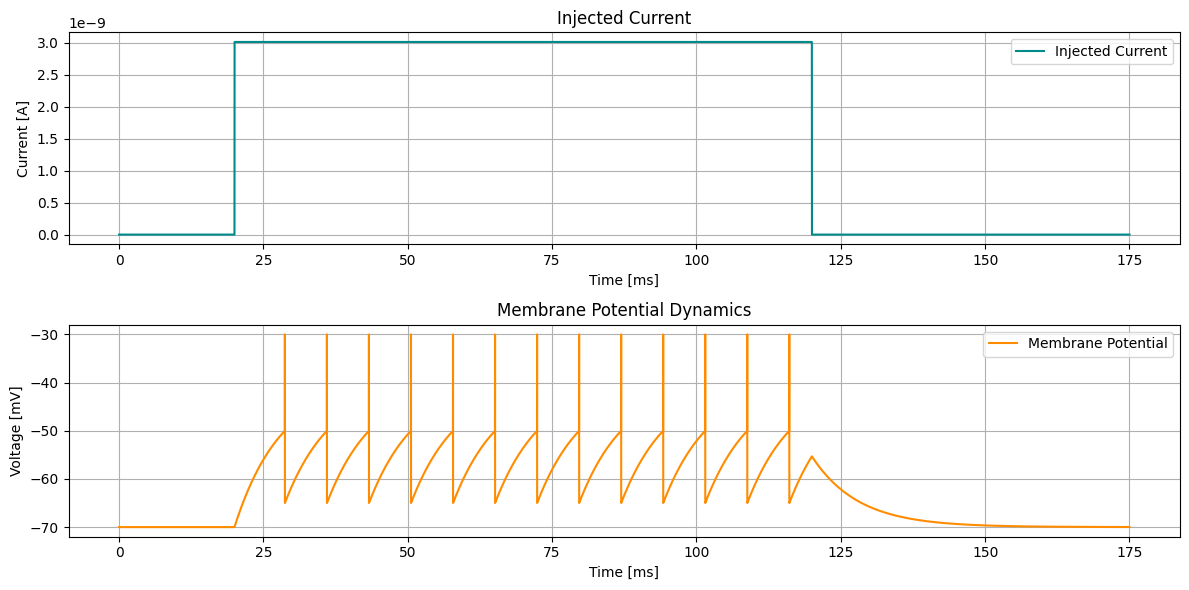

Total spikes: 13


In [4]:
def generate_current_profile(current_amplitude, duration, dt, inject_start_ms, inject_end_ms):
    total_steps = int(duration / dt) + 1
    current = np.zeros(total_steps)
    start_idx = int(inject_start_ms / dt)
    end_idx = int(inject_end_ms / dt)
    current[start_idx:end_idx] = current_amplitude
    return current

def simulate_LIF_neuron(current_input, gl, Cm, V_peak, V_rest, V_reset, V_threshold, time_vector):
    num_steps = len(time_vector)
    membrane_potential = np.empty(num_steps)
    membrane_potential[0] = V_rest
    spike_count = 0

    for t in range(1, num_steps):
        dV = (current_input[t] - gl * (membrane_potential[t - 1] - V_rest)) / Cm
        membrane_potential[t] = membrane_potential[t - 1] + dV * (time_vector[t] - time_vector[t - 1])

        if membrane_potential[t] > V_threshold:
            membrane_potential[t - 1] = V_peak
            membrane_potential[t] = V_reset
            spike_count += 1

    return membrane_potential, spike_count

def run_LIF_simulation():
    # Simulation parameters
    duration_ms = 175
    dt_ms = 0.01
    time_vector = np.arange(0, duration_ms + dt_ms, dt_ms)

    # Biophysical parameters
    gl_nS = 100        # [nS]
    Cm_pF = 800        # [pF]
    V_rest_mV = -70    # [mV]
    V_threshold_mV = -50
    V_reset_mV = -65
    V_peak_mV = -30
    I_pA = 3010        # [pA]

    # Input current injection window
    inject_start_ms = 20
    inject_end_ms = 120

    # Create input current array
    I_injected = generate_current_profile(I_pA, duration_ms, dt_ms, inject_start_ms, inject_end_ms)

    # Run simulation
    voltage_trace, spike_count = simulate_LIF_neuron(
        current_input=I_injected,
        gl=gl_nS,
        Cm=Cm_pF,
        V_peak=V_peak_mV,
        V_rest=V_rest_mV,
        V_reset=V_reset_mV,
        V_threshold=V_threshold_mV,
        time_vector=time_vector
    )

    # Convert units for plotting
    current_A = I_injected * 1e-12  # Convert pA to A

    # Plot results
    plt.figure("LIF Neuron Simulation", figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(time_vector, current_A, label='Injected Current', color='darkcyan')
    plt.ylabel("Current [A]")
    plt.xlabel("Time [ms]")
    plt.title("Injected Current")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time_vector, voltage_trace, label='Membrane Potential', color='darkorange')
    plt.ylabel("Voltage [mV]")
    plt.xlabel("Time [ms]")
    plt.title("Membrane Potential Dynamics")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Total spikes: {spike_count}")

# Run the simulation
run_LIF_simulation()

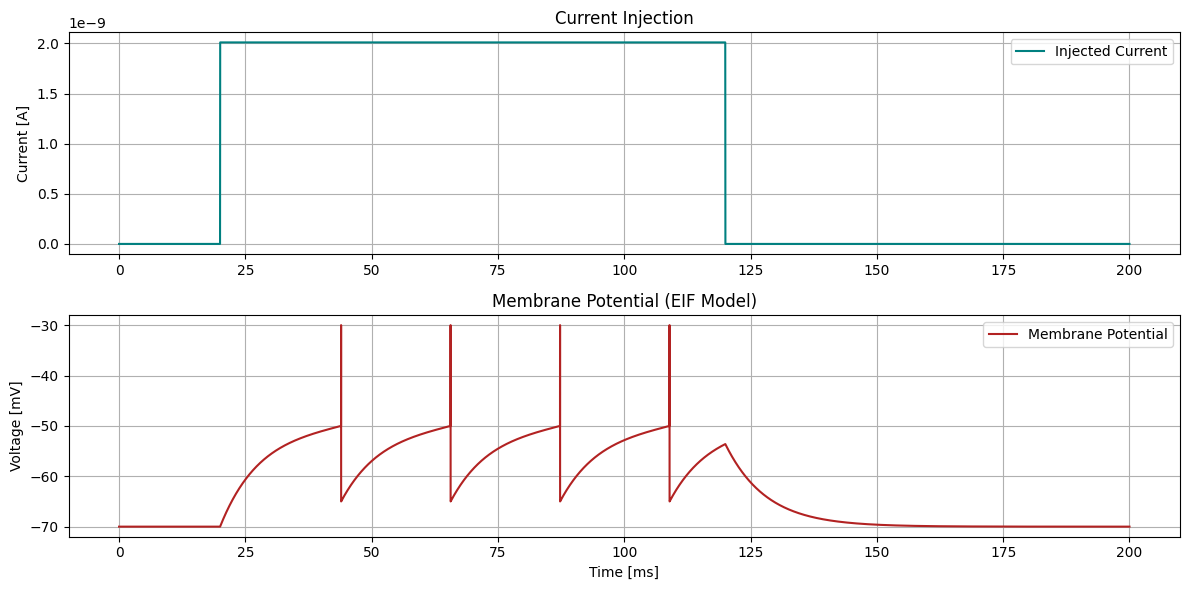

Spike count: 4


In [5]:
def generate_input_current(amplitude_pA, total_time_ms, dt_ms, start_ms=20, end_ms=120):
    """Generate step current input with configurable injection window."""
    total_steps = int(total_time_ms / dt_ms) + 1
    current = np.zeros(total_steps)
    start_idx = int(start_ms / dt_ms)
    end_idx = int(end_ms / dt_ms)
    current[start_idx:end_idx] = amplitude_pA
    return current

def simulate_EIF_neuron(I_input, gl_nS, Cm_pF, V_spike_mV, V_rest_mV, V_reset_mV, V_th_mV, delta_T_mV, time_vector):
    """Simulate the Exponential Integrate-and-Fire neuron dynamics."""
    num_steps = len(time_vector)
    V_m = np.empty(num_steps)
    V_m[0] = V_rest_mV
    spike_count = 0

    for t in range(1, num_steps):
        V_prev = V_m[t - 1]
        dV = (
            I_input[t - 1] 
            - gl_nS * (V_prev - V_rest_mV) 
            + gl_nS * delta_T_mV * np.exp((V_prev - V_th_mV) / delta_T_mV)
        ) / Cm_pF

        V_m[t] = V_prev + dV * (time_vector[t] - time_vector[t - 1])

        if V_m[t] > V_th_mV:
            V_m[t - 1] = V_spike_mV
            V_m[t] = V_reset_mV
            spike_count += 1

    return V_m, spike_count

def run_EIF_simulation():
    # Simulation Parameters
    duration_ms = 200
    dt_ms = 0.01
    time = np.arange(0, duration_ms + dt_ms, dt_ms)

    # Neuron Parameters
    gl = 100          # nS
    Cm = 800          # pF
    V_rest = -70      # mV
    V_th = -50        # mV
    V_reset = -65     # mV
    V_spike = -30     # mV
    delta_T = 2       # mV
    I_amp = 2010      # pA

    # Generate Input Current
    I_pA = generate_input_current(I_amp, duration_ms, dt_ms, start_ms=20, end_ms=120)

    # Simulate EIF Neuron
    Vm_trace, spike_count = simulate_EIF_neuron(
        I_input=I_pA,
        gl_nS=gl,
        Cm_pF=Cm,
        V_spike_mV=V_spike,
        V_rest_mV=V_rest,
        V_reset_mV=V_reset,
        V_th_mV=V_th,
        delta_T_mV=delta_T,
        time_vector=time
    )

    # Convert current to Amps for plotting
    I_A = I_pA * 1e-12

    # Plotting
    plt.figure("EIF Neuron Simulation", figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(time, I_A, label="Injected Current", color="teal")
    plt.ylabel("Current [A]")
    plt.title("Current Injection")
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(time, Vm_trace, label="Membrane Potential", color="firebrick")
    plt.xlabel("Time [ms]")
    plt.ylabel("Voltage [mV]")
    plt.title("Membrane Potential (EIF Model)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Spike count: {spike_count}")

# Execute simulation
run_EIF_simulation()


In [8]:
def adex_simulate(
    I_inj=1000,     # Injected current in [pA]
    gl=30,          # Leak conductance [nS]
    Cm=281,         # Membrane capacitance [pF]
    V_spike=-30,    # Artificial spike potential [mV]
    El=-70,         # Resting potential [mV]
    T=400,          # Simulation time [ms]
    dt=0.01,        # Time step [ms]
    V_reset=-65,    # Reset potential after spike [mV]
    V_th=-50,       # Threshold potential [mV]
    delta_T=2,      # Slope factor [mV]
    a=4,          # Subthreshold adaptation [nS]
    b=80,           # Spike-triggered adaptation [pA]
    tau_w=144       # Adaptation time constant [ms]
):
    time = np.arange(0, T + dt, dt)
    V = np.zeros_like(time)
    w = np.zeros_like(time)

    # Initial conditions
    V[0] = El
    I = np.zeros_like(time)
    I[1000:25000] = I_inj  # injected current in a time window

    spike_count = 0

    for i in range(1, len(time)):
        dVdt = (I[i-1] - gl*(V[i-1] - El) + gl*delta_T*np.exp((V[i-1] - V_th)/delta_T) - w[i-1]) / Cm
        dwdt = (a*(V[i-1] - El) - w[i-1]) / tau_w

        V[i] = V[i-1] + dt * dVdt
        w[i] = w[i-1] + dt * dwdt

        # Spike condition
        if V[i] >= V_th:
            V[i-1] = V_spike     # Show spike in plot
            V[i] = V_reset       # Reset membrane potential
            w[i] += b            # Increase adaptation current
            spike_count += 1

    return time, V, w, I, spike_count

def plot_adex_results(time, V, w, I):
    fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

    axs[0].plot(time, I, label="Input Current")
    axs[0].set_ylabel("I [pA]")
    axs[0].legend()
    axs[0].set_title("AdEx Neuron Simulation")
    axs[0].grid(True)
    
    axs[1].plot(time, V, label="Membrane Potential", color='tab:red')
    axs[1].set_ylabel("V [mV]")
    axs[1].legend()
    axs[1].grid(True)

    axs[2].plot(time, w, label="Adaptation Variable", color='tab:green')
    axs[2].set_ylabel("w [pA]")
    axs[2].set_xlabel("Time [ms]")
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


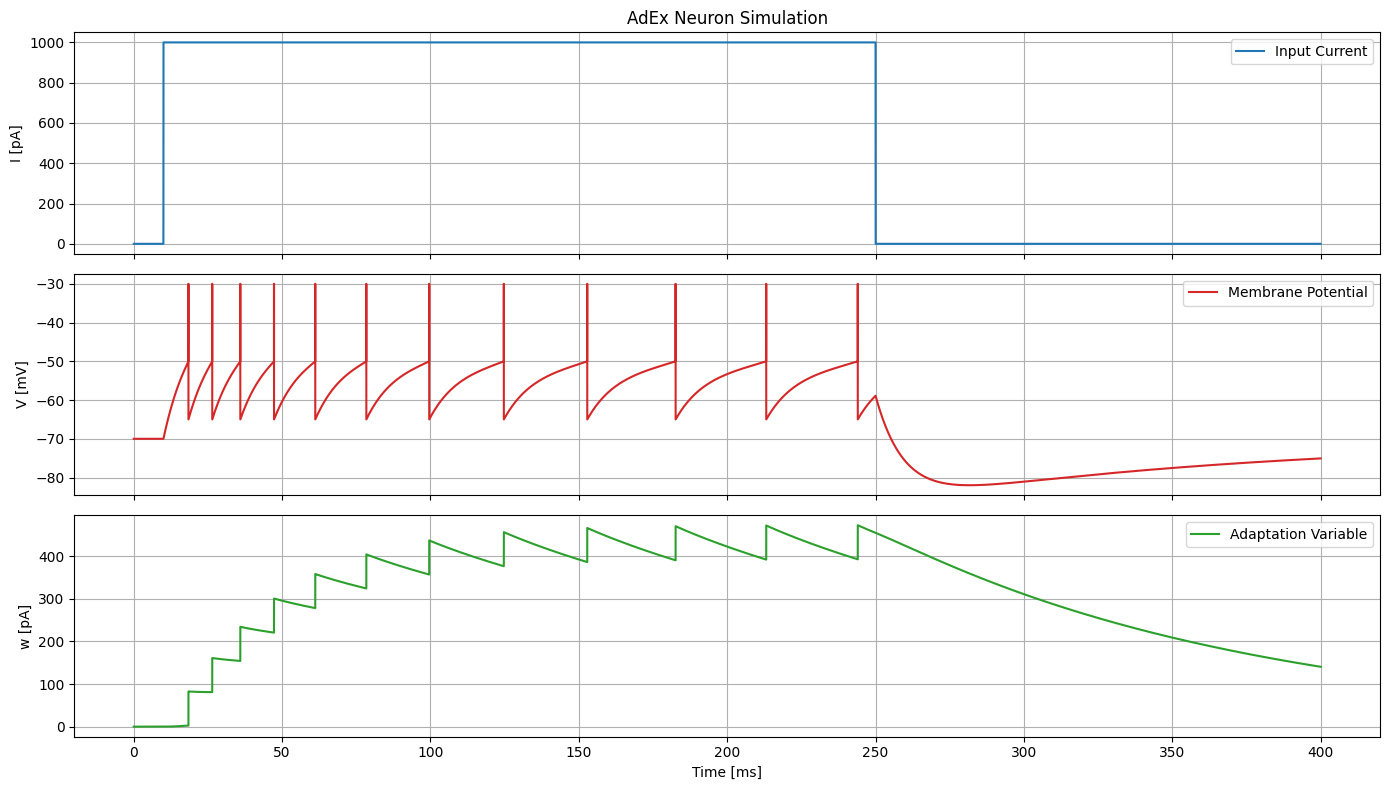

Total spikes: 12


In [9]:
time, V, w, I, spike_count = adex_simulate()
plot_adex_results(time, V, w, I)
print(f"Total spikes: {spike_count}")
